Histograms of data often reveal that they do not follow any standard probability distribution. Sometimes we have explanatory variables (or covariates) to account for the different values, and normally distributed errors are adequate, as in normal regression. However, if we only have the data values themselves and no covariates, we might have to fit a non-standard distribution to the data. One way to do this is by mixing standard distributions.

Mixture distributions are just a weighted combination of probability distribtuions. For example, we could take an exponential distribution with mean 1 and normal distribution with mean 3 and variance 1 (although typically the two mixture components would have the same support; here the exponential component has to be non-negative and the normal component can be positive or negative). Suppose we give them weights: 0.4 for the exponential distribution and 0.6 for the normal distribution. We could write the PDF for this distribution as
<br>
$$p(y) = 0.4 . exp(-y) . I_{(y>=0)} + 0.6 . \frac{1}{\sqrt{2\pi}} exp(-\frac{1}{2}(y-3)^{2})$$

The PDF of this mixture distribution would look like this:

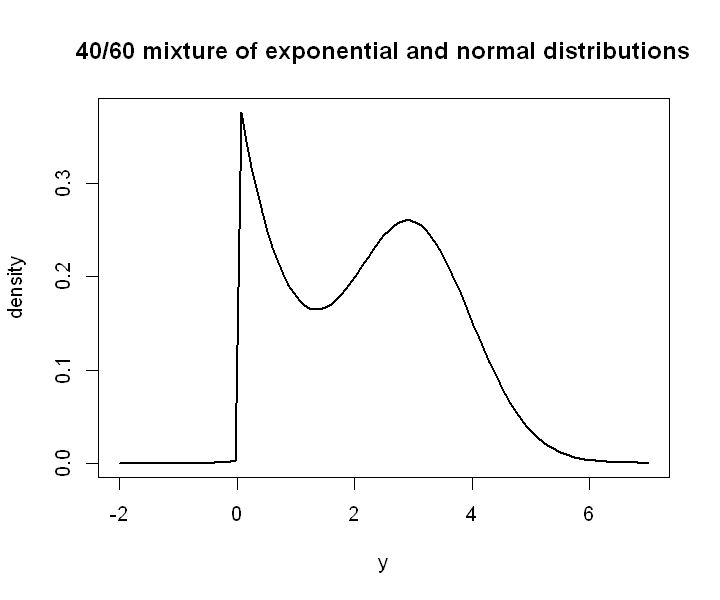

In [1]:
options(repr.plot.width = 6, repr.plot.height=5)

curve( 0.4*dexp(x, 1.0) + 0.6*dnorm(x, 3.0, 1.0), 
       from=-2.0, to=7.0, 
       ylab="density", 
       xlab="y", 
       main="40/60 mixture of exponential and normal distributions", 
       lwd=2)

We could think of these two distributions as governing two distinct populations, one following the exponential distribution and the other following the normal distribution.

Let’s draw the weighted PDFs for each population.

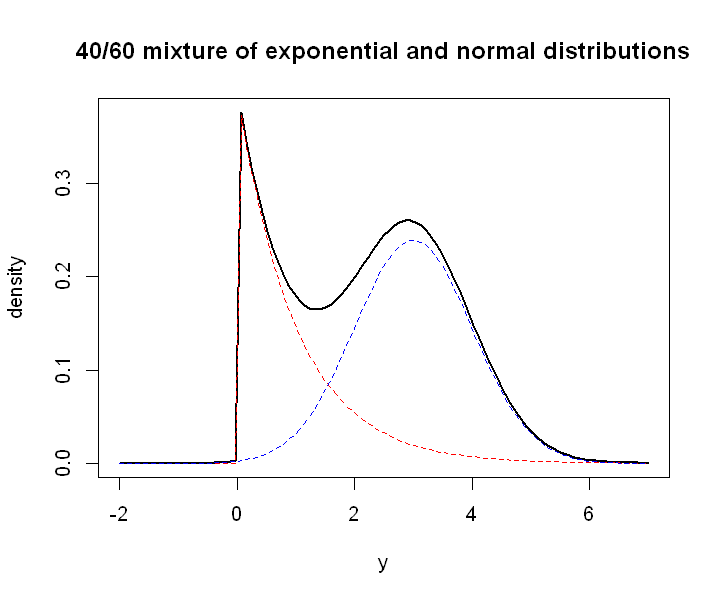

In [2]:
curve( 0.4*dexp(x, 1.0) + 0.6*dnorm(x, 3.0, 1.0), 
       from=-2.0, to=7.0, 
       ylab="density", 
       xlab="y", 
       main="40/60 mixture of exponential and normal distributions", 
       lwd=2)

curve( 0.4*dexp(x, 1.0), 
       from=-2.0, 
       to=7.0, 
       col="red", 
       lty=2, 
       add=TRUE)

curve( 0.6*dnorm(x, 3.0, 1.0), 
       from=-2.0, to=7.0, 
       col="blue", 
       lty=2, 
       add=TRUE)

The general form for a discrete mixture of distributions is as follows:

$$p(y) = \sum_{j=1}^{J}w_{j}.f_{j}(y)$$

where the $\omega$’s are positive weights that add up to 1 (they are probabilities) and each of the J $f_{j}(y)$ functions is a PDF for some distribution. In the example above, the weights were 0.4 and 0.6, $f_{1}$ was an exponential PDF and $f_{2}$ was a normal PDF.

One way to simulate from a mixture distribution is with a hierarchical model. We first simulate an indicator for which “population” the next observation will come from using the weights $\omega$. Let’s call this $z_{i}$. In the example above, $z_{i}$ would take the value 1 (indicating the exponential distribution) with probability 0.4 and 2 (indicating the normal distribution) with probability 0.6. Next, simulate the observation yi from the distribution corresponding to $z_{i}$.

In [3]:
set.seed(117)
n = 1000
z = numeric(n)
y = numeric(n)

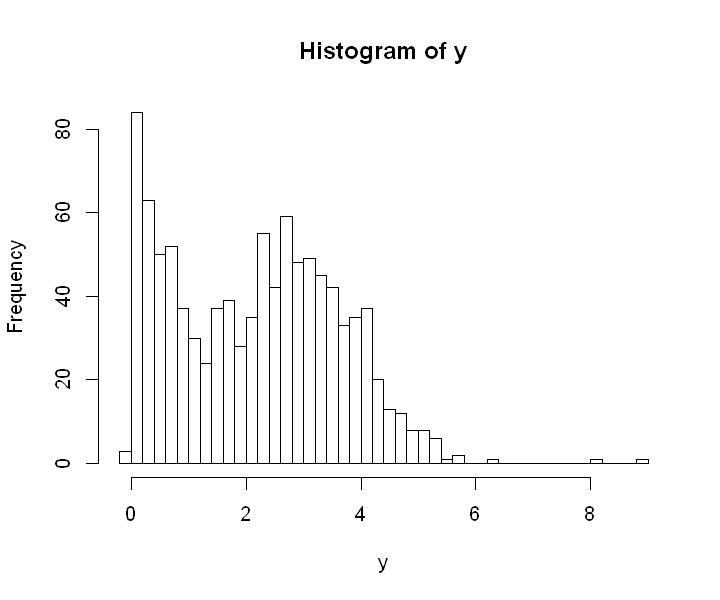

In [4]:
for(i in 1:n)
{
    # returns a 1 with probability 0.4, or a 2 with probability 0.6
    z[i] = sample.int(2, 1, prob = c(0.4, 0.6))
    if(z[i] == 1)
    {
        y[i] = rexp(1, rate = 1.0)
    }
    else
    {
        y[i] = rnorm(1, mean = 3.0, sd = 1.0)
    }
}

hist(y, breaks = 40)

# Bayesian Inference for mixture models

When we fit a mixture model to data, we usually only have the y values and do not know which “population” they belong to. Because the z variables are unobserved, they are called latent variables. We can treat them as parameters in a hierarchical model and perform Bayesian inference for them. The hierarchial model might look like this:

$$ y_{i} \, | \, z_{i},\theta \, = \, f_{z_{i}}(y \, | \, \theta \,) \,\,  i = 1,...,n $$<br>
$$Pr(z_{i} | j,w)  = w_{j}, j = 1,...,J$$<br>
$$ w ~ p(w)$$<br>
$$ \theta ~ p(\theta)$$

where we might use a Dirichlet prior (see the review of distributions in the supplementary material) for the weight vector ω and conjugate priors for the population-specific parameters in θ. With this model, we could obtain posterior distributions for z (population membership of the observations), ω (population weights), and θ (population-specific parameters in fj). Next, we will look at how to fit a mixture of two normal distributions in JAGS.

In [5]:
dat = read.csv("mixture.csv", header = FALSE)
y = dat$V1
(n = length(y))

[1] 200

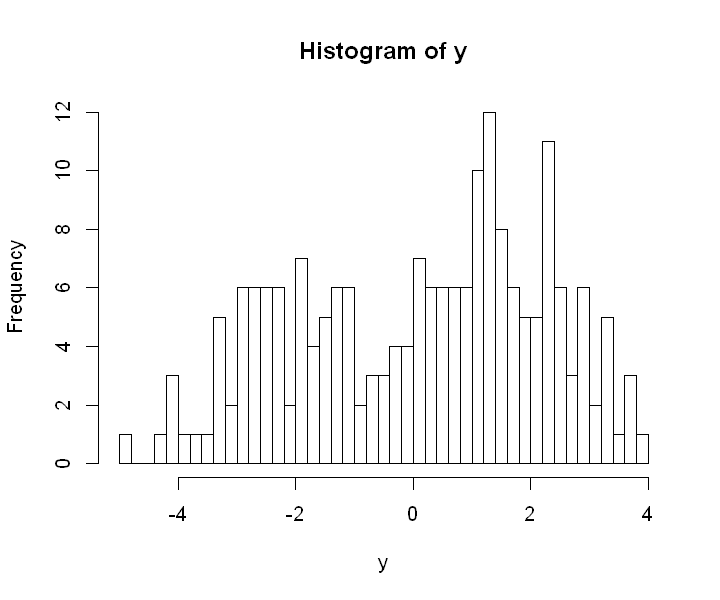

In [6]:
hist(y, breaks = 40)

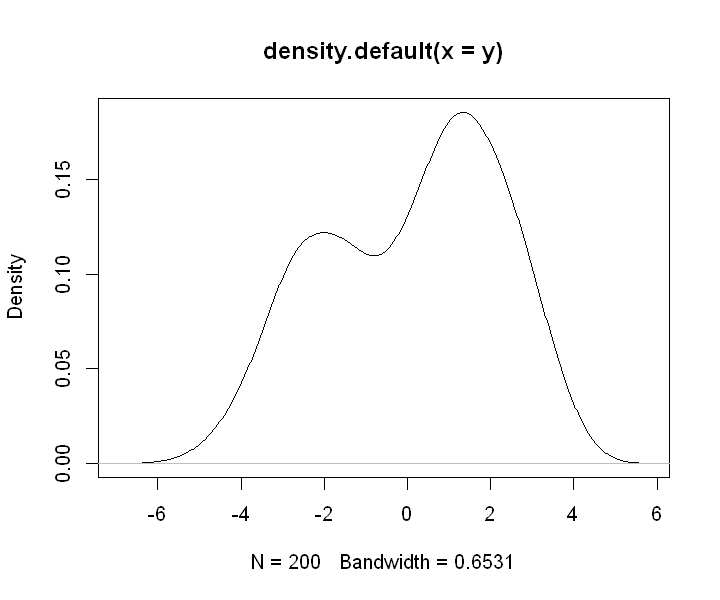

In [7]:
plot(density(y))

It appears that we have two populations, but we do not know which population each observation belongs to. We can learn this, along with the mixture weights and population-specific parameters with a Bayesian hierarchical model.

We will use a mixture of two normal distributions with variance 1 and different (and unknown) means.

In [8]:
library("rjags")
library("coda")

Warning message:
"package 'rjags' was built under R version 3.4.4"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [9]:
mod_string = " model {
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[z[i]], prec)
        z[i] ~ dcat(omega)
    }
    
    mu[1] ~ dnorm(-1.0, 1.0/1e2)
    mu[2] ~ dnorm(1.0, 1.0/1e2) T(mu[1],) # ensures mu[1] < mu[2]
    
    prec ~ dgamma(1.0/2.0, 1.0*1.0/2.0)
    sig = sqrt(1.0/prec)

    omega ~ ddirich(c(1.0, 1.0))
} "

In [10]:
set.seed(11)

In [11]:
data_jags = list(y=y)

In [12]:
params = c("mu", "sig", "omega", "z[1]", "z[31]", "z[49]", "z[6]") # Select some z's to monitor

mod = jags.model(textConnection(mod_string), 
                 data=data_jags, 
                 n.chains=3)
update(mod, 1e3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 204
   Total graph size: 614

Initializing model



In [13]:
mod_sim = coda.samples(model=mod,
                        variable.names=params,
                        n.iter=5e4)

mod_csim = as.mcmc(do.call(rbind, mod_sim))

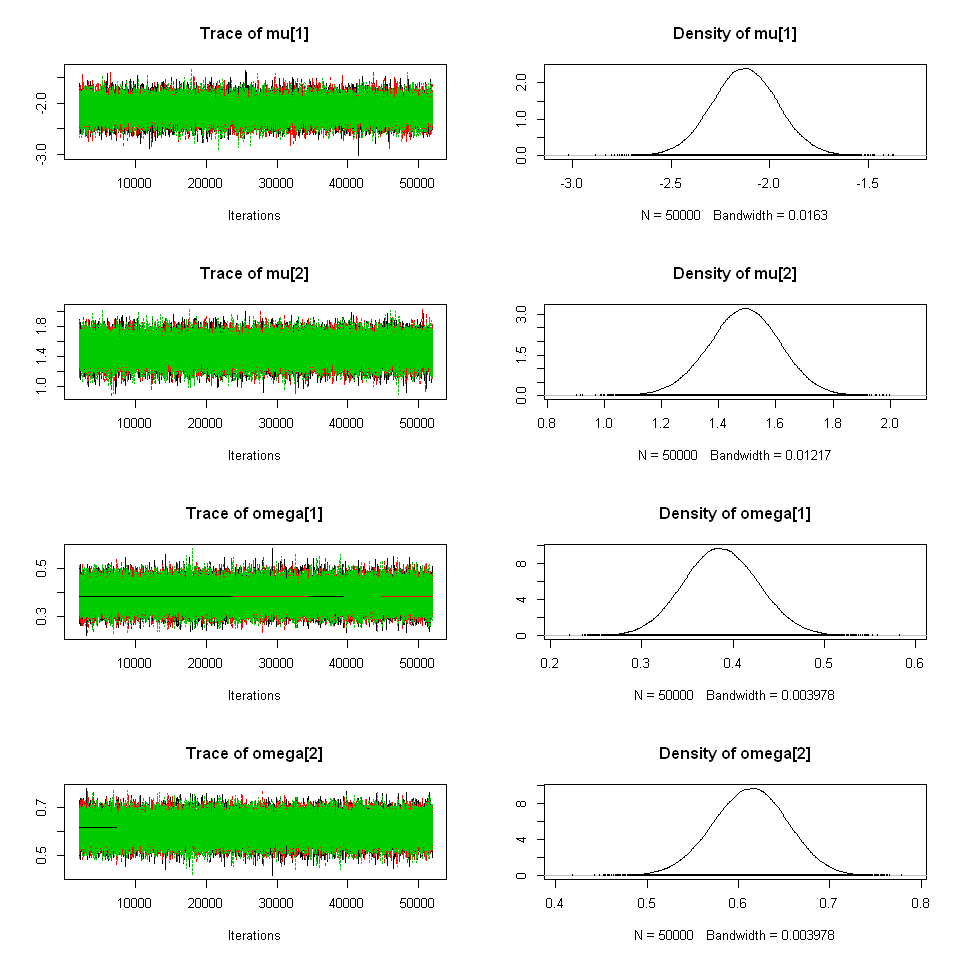

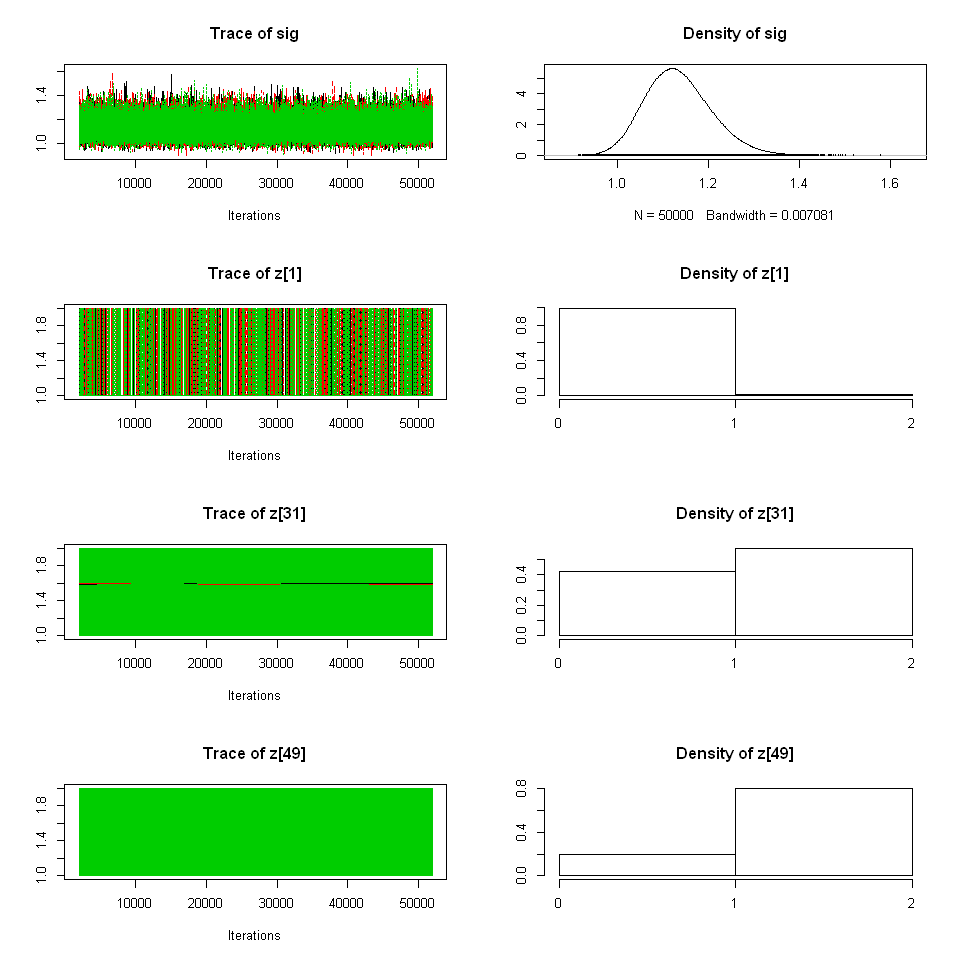

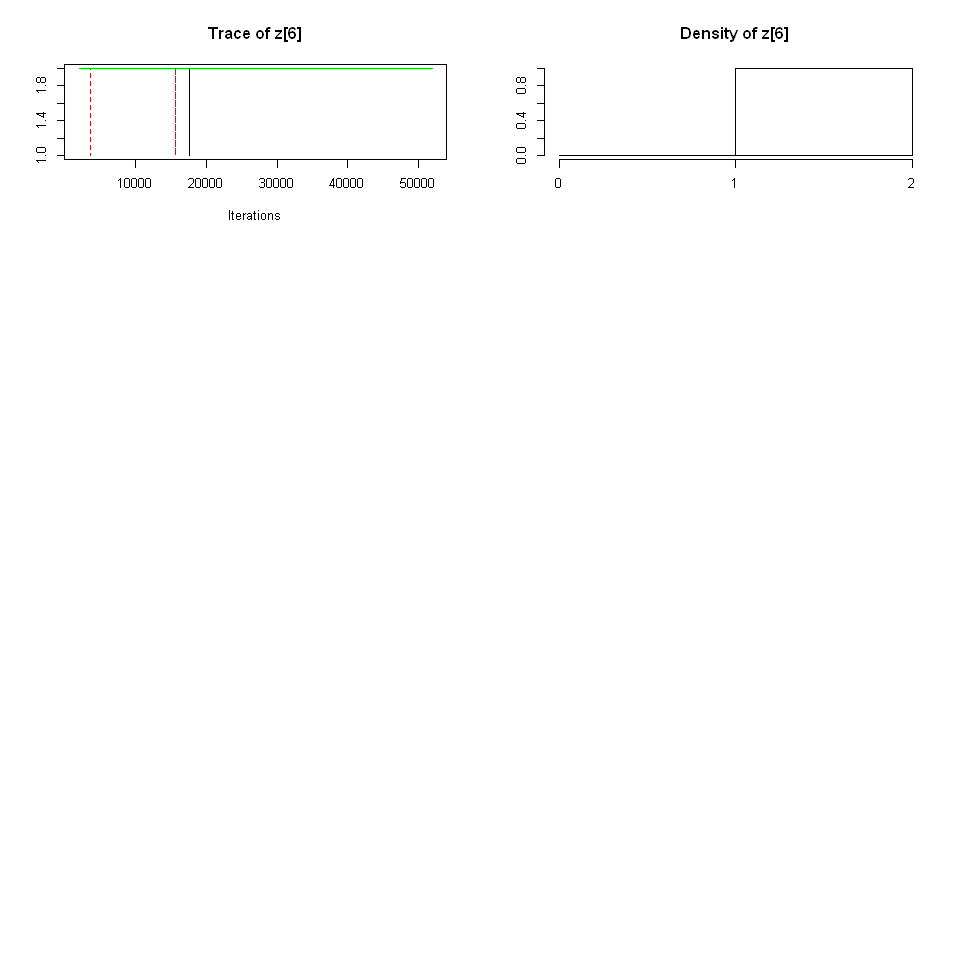

In [14]:
## convergence diagnostics
options(repr.plot.height=8, repr.plot.width=8)

plot(mod_sim, ask=TRUE)

In [15]:
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

,mu[1],mu[2],omega[1],omega[2],sig,z[1],z[31],z[49],z[6]
Lag 0,1.000000000,1.0000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.0000000000,NaN
Lag 1,0.536099339,0.3384676314,0.295383596,0.295383596,0.403606508,0.005039109,0.0422154937,0.0286155098,NaN
Lag 5,0.087021215,0.0459193965,0.043485679,0.043485679,0.025646252,-0.001876947,0.0057659168,0.0046831708,NaN
Lag 10,0.004709923,0.0008958866,-0.001487281,-0.001487281,0.003159687,-0.001110068,0.0027979663,0.0006938540,NaN
Lag 50,0.007356007,-0.0009672351,0.005605020,0.005605020,0.003668588,-0.004174102,0.0006498841,-0.0002232669,NaN


mu[1]     mu[2]  omega[1]  omega[2]       sig      z[1]     z[31]     z[49] 
 38739.52  55459.73  60308.33  60308.33  58498.97 143540.96 128250.05 131235.78 
     z[6] 
100000.00

# Result

In [16]:
summary(mod_sim)


Iterations = 2001:52000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
mu[1]    -2.1253 0.167052 4.313e-04      8.487e-04
mu[2]     1.4896 0.125886 3.250e-04      5.346e-04
omega[1]  0.3872 0.040697 1.051e-04      1.657e-04
omega[2]  0.6128 0.040697 1.051e-04      1.657e-04
sig       1.1353 0.073732 1.904e-04      3.049e-04
z[1]      1.0087 0.093079 2.403e-04      2.457e-04
z[31]     1.5748 0.494378 1.276e-03      1.381e-03
z[49]     1.8044 0.396699 1.024e-03      1.095e-03
z[6]      2.0000 0.004472 1.155e-05      1.155e-05

2. Quantiles for each variable:

            2.5%     25%     50%     75%   97.5%
mu[1]    -2.4518 -2.2371 -2.1259 -2.0136 -1.7952
mu[2]     1.2373  1.4072  1.4911  1.5741  1.7331
omega[1]  0.3086  0.3594  0.3867  0.4145  0.4682
omega[2]  0.5318  0.5855  0.6133  0.6406  0.6914
sig       1.

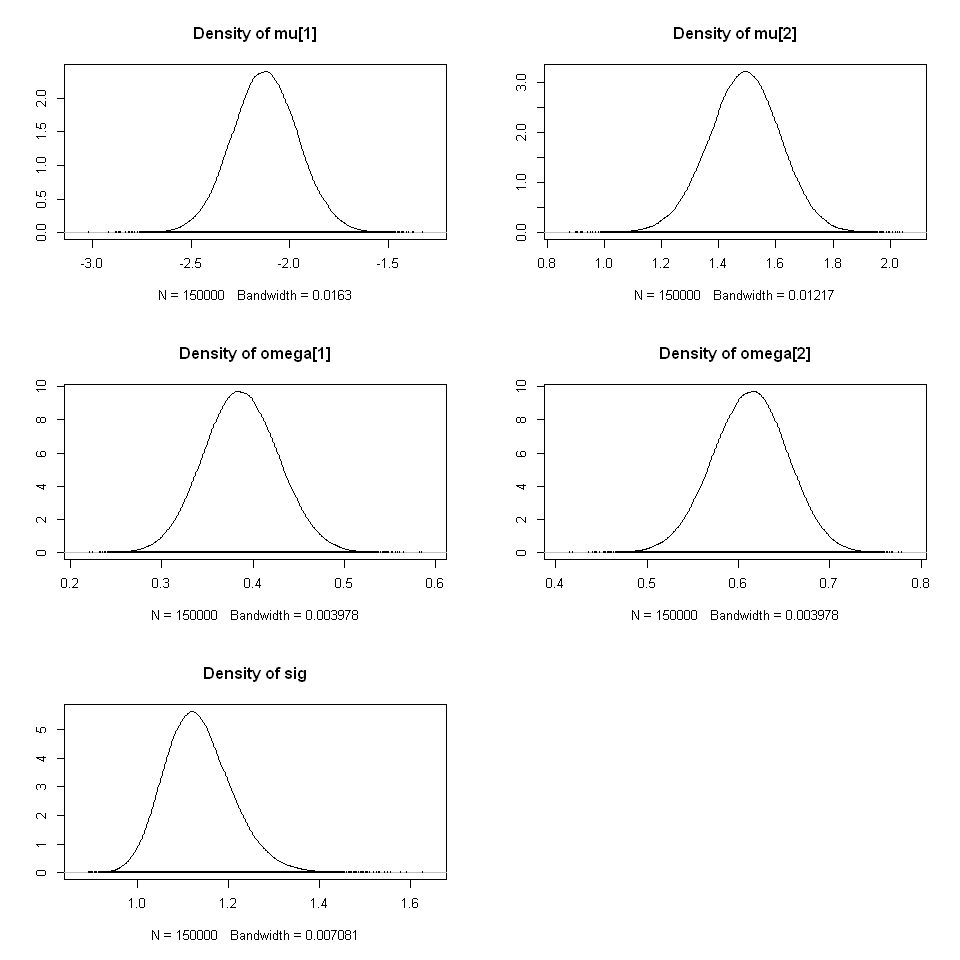

In [17]:
par(mfrow=c(3,2))
densplot(mod_csim[,c("mu[1]", "mu[2]", "omega[1]", "omega[2]", "sig")])

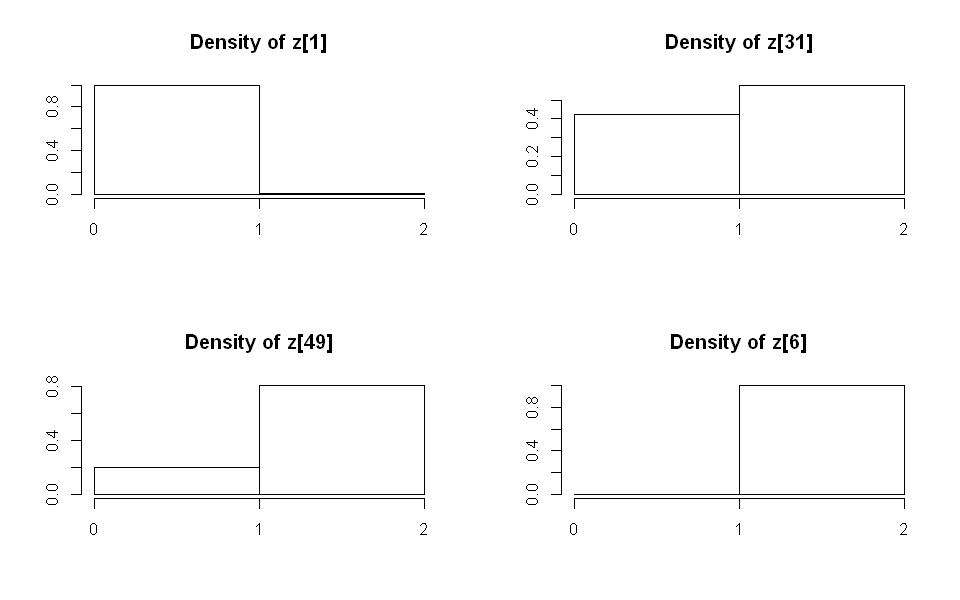

In [18]:
## for the z's
options(repr.plot.height = 5, repr.ploy.width=8)
par(mfrow=c(2,2))

densplot(mod_csim[,c("z[1]", "z[31]", "z[49]", "z[6]")])

In [19]:
table(mod_csim[,"z[1]"]) / nrow(mod_csim)


      1       2 
0.99126 0.00874 

In [20]:
table(mod_csim[,"z[31]"]) / nrow(mod_csim)


      1       2 
0.42522 0.57478 

In [21]:
table(mod_csim[,"z[49]"]) / nrow(mod_csim)


        1         2 
0.1956467 0.8043533 

In [22]:
table(mod_csim[,"z[6]"]) / nrow(mod_csim)


      1       2 
0.00002 0.99998 

In [23]:
y[c(1, 31, 49, 6)]

[1] -2.2661749 -0.3702666  0.0365564  3.7548080

If we look back to the y values associated with these z variables we monitored, we see that y1 is clearly in Population 1’s territory, y31 is ambiguous, y49 is ambiguous but is closer to Population 2’s territory, and y6 is clearly in Population 2’s territory. The posterior distributions for the z variables closely reflect our assessment.

In [24]:
# Ignore this part.

# Poisson Example

In [25]:
dat = read.csv("callers.csv")

In [26]:
head(dat)

calls,days_active,isgroup2,age
2,32,0,27
4,81,0,32
0,41,0,22
1,36,0,28
0,55,0,31
0,25,0,33


In [27]:
mod_str = " model {
    # Likelihood
    for (i in 1:length(calls)) {
        calls[i] ~ dpois( days_active[i] * lam[i] )
        log(lam[i]) = b[1] + b[2]*age[i] + b[3]*isgroup2[i]
    }

    # Priors
    for(j in 1:3){
        b[j] ~ dnorm(0, 1/1e4)
    }
} "

In [28]:
mod = jags.model(textConnection(mod_str), data = as.list(dat), n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 224
   Unobserved stochastic nodes: 3
   Total graph size: 1218

Initializing model



In [29]:
update(mod, 5e3)

In [30]:
params = c("b")

In [31]:
mod_sim = coda.samples(mod, variable.names = params, n.iter = 1e4)

In [32]:
mod_csim = as.mcmc(do.call(rbind, mod_sim))

In [33]:
colMeans(mod_csim)

b[1]        b[2]        b[3] 
-2.63400033 -0.06295602  1.54700626

In [34]:
# Calculate the probability that a person of age 29 who is in group2, calls atleast 3 times a day.

lamb = exp(mod_csim[,1] + mod_csim[,2]*29 + mod_csim[,3]*1) * 30

In [35]:
sum(rpois(30000, lamb) >= 3.0)/30000

[1] 0.2296333